In [1]:
import argparse
import logging
import pprint
import os
import sys
from itertools import chain
from collections import Counter

import torch
import torch.utils.data
import torch.nn.functional as F
import transformers
import datasets
import wandb

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import class_attention as cat

# Prepare and train a model

In [2]:
class args:
    dataset = "../data/news-category-semantic-split-small"
    model = "distilbert-base-uncased"
    test_class_frac = 0.0
    dataset_frac = 1.0
    batch_size = 32
    device = "cuda:1"
    lr = 1e-4
    max_epochs = 10
    normailze_cls = True
    normalize_txt = True
    scale_attention = False
    learn_temperature = True
    use_n_projection_layers = None
    share_txt_cls_network_params = True


In [3]:
(
    train_dataloader,
    test_dataloader,
    all_classes_str,
    test_classes_str,
) = cat.training_utils.prepare_dataloaders(
    dataset_name_or_path=args.dataset,
    model_name=args.model,
    test_class_frac=args.test_class_frac,
    dataset_frac=args.dataset_frac,
    batch_size=args.batch_size,
)


In [4]:
text_encoder = transformers.AutoModel.from_pretrained(args.model)
label_encoder = transformers.AutoModel.from_pretrained(args.model)

model = cat.ClassAttentionModel(
    text_encoder,
    label_encoder,
    **vars(args),
)
model = model.to(args.device)

In [5]:
parameters = model.get_trainable_parameters()
optimizer = torch.optim.Adam(parameters, lr=args.lr)

config = {k: v for k, v in vars(args).items() if not k.startswith("_")}

wandb.init(project="class_attention", config=config, tags=["notebook"])
wandb.watch(model, log="all")

wandb: Currently logged in as: guitaricet (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
model = cat.training_utils.train_cat_model(
    model,
    optimizer,
    train_dataloader,
    test_dataloader,
    all_classes_str,
    test_classes_str,
    args.max_epochs,
    args.device,
)

# Error analysis

In [7]:
text_tokenizer = test_dataloader.dataset.text_tokenizer
label_tokenizer = test_dataloader.dataset.label_tokenizer

_t, _c = test_dataloader.dataset[4]
text_tokenizer.decode(_t), label_tokenizer.decode(_c)

("[CLS] behind closed doors, donald trump's adviser explains his real economic plan [SEP]",
 '[CLS] politics [SEP]')

In [8]:
set(all_classes_str).difference(test_classes_str)

{'ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN'}

In [9]:
test_classes_str

['WORLD NEWS',
 'STYLE',
 'EDUCATION',
 'PARENTS',
 'LATINO VOICES',
 'WORLDPOST',
 'DIVORCE',
 'CULTURE & ARTS']

In [10]:
news_dataset = datasets.load_from_disk("../data/news-category-semantic-split-small")
_, only_test_classes_data = cat.utils.split_classes(news_dataset["validation"], test_classes=test_classes_str)

otc_dataset = cat.CatDataset(
    only_test_classes_data["headline"],
    text_tokenizer,
    only_test_classes_data["category"],
    label_tokenizer,
)

test_classes_ids = label_tokenizer.batch_encode_plus(
    test_classes_str,
    return_tensors="pt",
    add_special_tokens=True,
    padding=True,
)["input_ids"]

otc_collator = cat.CatTestCollator(
    possible_labels_ids=test_classes_ids, pad_token_id=label_tokenizer.pad_token_id
)

otc_dataloader = torch.utils.data.DataLoader(otc_dataset, collate_fn=otc_collator, shuffle=False, pin_memory=True)

In [11]:
metrics = cat.utils.evaluate_model_per_class(
    model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics

2021-02-23 18:28:48 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 18:28:48 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 18:28:48 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.4615, device='cuda:1'),
 'P/WORLD NEWS': 0.0,
 'R/WORLD NEWS': 0.0,
 'F1/WORLD NEWS': 0.0,
 'P/STYLE': 0.7142857040816327,
 'R/STYLE': 0.6249999921875001,
 'F1/STYLE': 0.6666666080000038,
 'P/EDUCATION': 0.18181818016528928,
 'R/EDUCATION': 0.6666666444444452,
 'F1/EDUCATION': 0.28571424795918726,
 'P/PARENTS': 0.55999999776,
 'R/PARENTS': 0.7368421013850416,
 'F1/PARENTS': 0.6363635844008302,
 'P/LATINO VOICES': 0.33333332777777785,
 'R/LATINO VOICES': 0.39999999200000014,
 'F1/LATINO VOICES': 0.3636363074380234,
 'P/WORLDPOST': 0.3928571414540816,
 'R/WORLDPOST': 0.7333333284444445,
 'F1/WORLDPOST': 0.5116278591671213,
 'P/DIVORCE': 0.8749999890625002,
 'R/DIVORCE': 0.3043478247637051,
 'F1/DIVORCE': 0.45161286201873363,
 'P/CULTURE & ARTS': 0.4999999750000013,
 'R/CULTURE & ARTS': 0.24999999375000015,
 'F1/CULTURE & ARTS': 0.33333327777778377,
 'R_zero_shot': 0.4645237346218921,
 'P_zero_shot': 0.4446617894126604,
 'F1_zero_shot': 0.4061193433452104}

In [12]:
random_model = cat.ClassAttentionModel(
    transformers.AutoModel.from_config(transformers.AutoConfig.from_pretrained(args.model)),
    transformers.AutoModel.from_config(transformers.AutoConfig.from_pretrained(args.model)),
)

metrics_random = cat.utils.evaluate_model_per_class(
    random_model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics_random

2021-02-23 18:28:51 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 18:28:51 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 18:28:51 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.0440, device='cuda:1'),
 'P/WORLD NEWS': 0.0,
 'R/WORLD NEWS': 0.0,
 'F1/WORLD NEWS': 0.0,
 'P/STYLE': 0.0,
 'R/STYLE': 0.0,
 'F1/STYLE': 0.0,
 'P/EDUCATION': 0.0,
 'R/EDUCATION': 0.0,
 'F1/EDUCATION': 0.0,
 'P/PARENTS': 0.0,
 'R/PARENTS': 0.0,
 'F1/PARENTS': 0.0,
 'P/LATINO VOICES': 0.0,
 'R/LATINO VOICES': 0.0,
 'F1/LATINO VOICES': 0.0,
 'P/WORLDPOST': 0.0,
 'R/WORLDPOST': 0.0,
 'F1/WORLDPOST': 0.0,
 'P/DIVORCE': 0.0,
 'R/DIVORCE': 0.0,
 'F1/DIVORCE': 0.0,
 'P/CULTURE & ARTS': 0.049382715988416405,
 'R/CULTURE & ARTS': 0.9999999750000006,
 'F1/CULTURE & ARTS': 0.09411763786851278,
 'R_zero_shot': 0.12499999687500007,
 'P_zero_shot': 0.006172839498552051,
 'F1_zero_shot': 0.011764704733564097}

In [13]:
bert_model = cat.ClassAttentionModel(
    transformers.AutoModel.from_pretrained(args.model),
    transformers.AutoModel.from_pretrained(args.model),
)

metrics_bert = cat.utils.evaluate_model_per_class(
    bert_model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics_bert

2021-02-23 18:28:54 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 18:28:54 | WARNING | utils.py | No classes for the group multi_shot
2021-02-23 18:28:54 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.0440, device='cuda:1'),
 'P/WORLD NEWS': 0.0,
 'R/WORLD NEWS': 0.0,
 'F1/WORLD NEWS': 0.0,
 'P/STYLE': 0.0,
 'R/STYLE': 0.0,
 'F1/STYLE': 0.0,
 'P/EDUCATION': 0.0,
 'R/EDUCATION': 0.0,
 'F1/EDUCATION': 0.0,
 'P/PARENTS': 0.0,
 'R/PARENTS': 0.0,
 'F1/PARENTS': 0.0,
 'P/LATINO VOICES': 0.0,
 'R/LATINO VOICES': 0.0,
 'F1/LATINO VOICES': 0.0,
 'P/WORLDPOST': 0.0,
 'R/WORLDPOST': 0.0,
 'F1/WORLDPOST': 0.0,
 'P/DIVORCE': 0.0,
 'R/DIVORCE': 0.0,
 'F1/DIVORCE': 0.0,
 'P/CULTURE & ARTS': 0.04395604390774061,
 'R/CULTURE & ARTS': 0.9999999750000006,
 'F1/CULTURE & ARTS': 0.08421051807202275,
 'R_zero_shot': 0.12499999687500007,
 'P_zero_shot': 0.0054945054884675765,
 'F1_zero_shot': 0.010526314759002843}

In [14]:
class_counts = Counter(otc_dataloader.dataset.labels)
class_counts

Counter({'WORLDPOST': 15,
         'PARENTS': 19,
         'WORLD NEWS': 14,
         'DIVORCE': 23,
         'STYLE': 8,
         'EDUCATION': 3,
         'LATINO VOICES': 5,
         'CULTURE & ARTS': 4})

In [15]:
{k: v / len(otc_dataloader.dataset) for k, v in class_counts.most_common()}

{'DIVORCE': 0.25274725274725274,
 'PARENTS': 0.2087912087912088,
 'WORLDPOST': 0.16483516483516483,
 'WORLD NEWS': 0.15384615384615385,
 'STYLE': 0.08791208791208792,
 'LATINO VOICES': 0.054945054945054944,
 'CULTURE & ARTS': 0.04395604395604396,
 'EDUCATION': 0.03296703296703297}

## Result

Parameter sharing between encoder and decoder does not improve the model

# Logit magnitudes

In [18]:
x, c, y = next(iter(test_dataloader))

In [27]:
x.shape

torch.Size([32, 22])

In [25]:
x_np = x.detach().cpu().numpy()

In [29]:
x_lt = x.split(x.size(0), dim=0)
len(x_lt), x_lt[0].shape

(1, torch.Size([32, 22]))

In [45]:
results = []  # (class, logits)

for x, c, y in tqdm(test_dataloader):
    x = x.to(args.device)
    c = c.to(args.device)

    logits = model(x, c)
    
    logits = logits.detach().cpu()
    y = y.detach().cpu()

    for logit, class_idx in zip(logits, y):
        results.append((logit, class_idx, all_classes_str[class_idx]))

100%|██████████| 459/459 [00:09<00:00, 49.59it/s]


In [46]:
len(results)

14661

In [47]:
results[0]

(tensor([-0.1697,  5.2545,  1.3604, -1.5482, -1.7359, -0.8953, -0.2256, -2.0814,
         -2.5970,  3.5153, -0.4110, -1.7011, -1.4898, 12.9483,  1.3402, -1.5641,
         -0.9442, -1.8485,  0.2434,  0.6873, -0.5288,  1.4669,  0.3661, -2.2788,
          1.3789, -2.2339, -2.3749, -0.4878, -0.9802, -0.6369, -0.2317,  0.6695,
         -1.9313,  2.1309,  0.3318,  1.0260, -1.8495,  1.1455,  0.1246,  0.3142,
         -2.0768]),
 tensor(13),
 'SCIENCE')

In [53]:
average_abs_logit = sum(l.abs() for l, i, c in results) / len(results)
average_abs_logit

tensor([1.4479, 1.2758, 1.8125, 2.2326, 2.0475, 1.5982, 1.2594, 1.9460, 1.9379,
        2.0554, 1.7219, 1.7585, 1.4908, 1.3209, 1.5206, 1.4892, 1.7789, 2.1790,
        1.6923, 2.6788, 1.6963, 1.9745, 2.1161, 1.9878, 1.3302, 1.8232, 1.4762,
        2.1975, 1.7550, 1.2899, 1.5110, 1.7722, 1.7730, 1.3812, 2.1671, 1.4764,
        1.5007, 3.6519, 1.6794, 1.7411, 1.2774])

In [66]:
test_classes_str

['WORLD NEWS',
 'STYLE',
 'EDUCATION',
 'PARENTS',
 'LATINO VOICES',
 'WORLDPOST',
 'DIVORCE',
 'CULTURE & ARTS']

<BarContainer object of 41 artists>

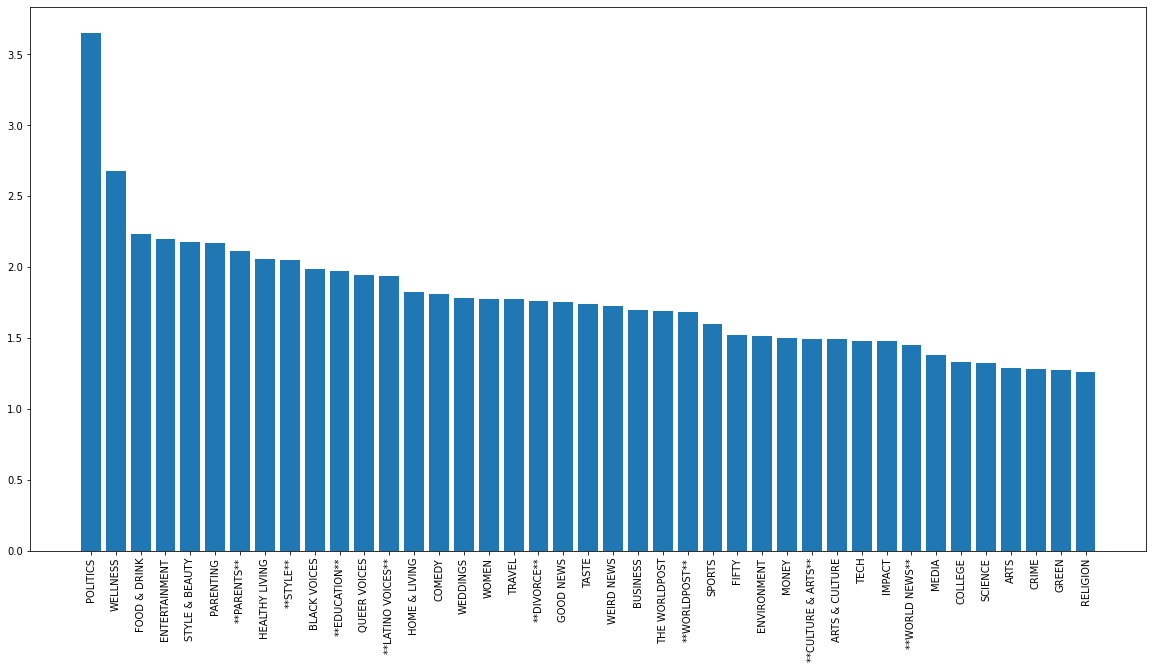

In [69]:
all_classes_str_with_marks = ["**" + c + "**" if c in test_classes_str else c for c in all_classes_str]
sorted_pairs = sorted(list(zip(all_classes_str_with_marks, average_abs_logit)), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.bar(*(zip(*sorted_pairs)))